In [96]:
import json 
import glob
import matplotlib.pyplot as plt
import pandas as pd 
from transformers import BertModel
from transformers import BertConfig
import torch
import torch.nn.utils.prune as prune

In [ ]:
list_01 = [] 
list_03 = [] 
list_045 = [] 
list_0495 = [] 

list_07 = [] 
list_09 = [] 
list_095 = [] 
list_099 = [] 




In [10]:
ss = [0.1,0.3,0.45,0.495,0.7,0.9,0.95,0.99]
prefs = ["global","random","lower-only","upper-only"]
names = ["base"] 
for s in ss: 
    sts = 4 
    if s >= 0.7: 
        sts = 2
    for i in range(sts):
        names.append(prefs[i] + "-" + str(s))
print(names)

headers = ["Sparsity", "MLM acc", "MLM ppl", "MNLI acc", "MRPC acc", "MRPC f1", 
           "MRPC combined", "QNLI acc", "SST2 acc", "STSB pearsonr", "STSB spearmanr", "STSB combined"]
print(headers)

['base', 'global-0.1', 'random-0.1', 'lower-only-0.1', 'upper-only-0.1', 'global-0.3', 'random-0.3', 'lower-only-0.3', 'upper-only-0.3', 'global-0.45', 'random-0.45', 'lower-only-0.45', 'upper-only-0.45', 'global-0.495', 'random-0.495', 'lower-only-0.495', 'upper-only-0.495', 'global-0.7', 'random-0.7', 'global-0.9', 'random-0.9', 'global-0.95', 'random-0.95', 'global-0.99', 'random-0.99']
['Sparsity', 'MLM acc', 'MLM ppl', 'MNLI acc', 'MRPC acc', 'MRPC f1', 'MRPC combined', 'QNLI acc', 'SST2 acc', 'STSB pearsonr', 'STSB spearmanr', 'STSB combined']


In [73]:
def get_metrics(method, sparsity): 
    ret = {}
    glob_string = method + '-results/bert-' + str(sparsity) + '/*/eval_results.json'
    for i in glob.glob(glob_string):
        if "mlm" in i: 
            ret["mlm_acc"] = json.load(open(i,'r'))["eval_accuracy"]
            ret["mlm_ppl"] = json.load(open(i,'r'))["perplexity"]
        if "mnli" in i:
            ret["mnli_acc"] = json.load(open(i,'r'))["eval_accuracy"]
        if "mrpc" in i:
            ret["mrpc_acc"] = json.load(open(i,'r'))["eval_accuracy"]
            ret["mrpc_f1"] = json.load(open(i,'r'))["eval_f1"]
            ret["mrpc_combined"] = json.load(open(i,'r'))["eval_combined_score"]
        if "qnli" in i:
            ret["qnli_acc"] = json.load(open(i,'r'))["eval_accuracy"]
        if "sst2" in i: 
            ret["sst2_acc"] = json.load(open(i,'r'))["eval_accuracy"]
        if "stsb" in i:
            ret["stsb_pearsonr"] = json.load(open(i,'r'))["eval_pearson"]
            ret["stsb_spearmanr"] = json.load(open(i,'r'))["eval_spearmanr"]
            ret["stsb_combined"] = json.load(open(i,'r'))["eval_combined_score"]
            
            
            
            
            
    
    return ret
    
    

In [84]:

methods = ["full","random","upper","lower"]
sparsities = [0,0.1,0.3,0.45,0.495,0.7,0.9,0.95,0.99]

res_list = [] 
for s in sparsities:
    amt = 4 
    if s >= 0.7:
        amt = 2
    if s == 0:
        amt = 1
    for j in range(amt):
        if s == 0: 
            res_list.append((methods[j]+'-base',get_metrics(methods[j],"base")))
        else:
            res_list.append((methods[j]+'-'+str(s),get_metrics(methods[j],s)))
            
ind = [mod[0] for mod in res_list]
print(ind)

['full-base', 'full-0.1', 'random-0.1', 'upper-0.1', 'lower-0.1', 'full-0.3', 'random-0.3', 'upper-0.3', 'lower-0.3', 'full-0.45', 'random-0.45', 'upper-0.45', 'lower-0.45', 'full-0.495', 'random-0.495', 'upper-0.495', 'lower-0.495', 'full-0.7', 'random-0.7', 'full-0.9', 'random-0.9', 'full-0.95', 'random-0.95', 'full-0.99', 'random-0.99']


In [83]:
# print(res_list[1][1].keys())
new_dict = {}
for key in res_list[1][1].keys():
    insert = [v[1][key] for v in res_list]
    new_dict[key] = insert 
    

In [87]:
df = pd.DataFrame(data=new_dict,index=ind)
df.to_csv('all_results.csv')

In [154]:
model = BertModel.from_pretrained('full_prune/bert-0.9/')


In [179]:
def see_weight_rate(sparsity):
    
    path = 'full_prune/bert-' + str(sparsity) + '/'
    model = BertModel.from_pretrained(path)
    sum_list = 0
    zero_sum = 0
    layers = [] 
    for ii in range(12):
        sum_list = sum_list+float(model.encoder.layer[ii].attention.self.query.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].attention.self.query.weight == 0))

        sum_list = sum_list+float(model.encoder.layer[ii].attention.self.key.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].attention.self.key.weight == 0))

        sum_list = sum_list+float(model.encoder.layer[ii].attention.self.value.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].attention.self.value.weight == 0))

        sum_list = sum_list+float(model.encoder.layer[ii].attention.output.dense.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].attention.output.dense.weight == 0))

        sum_list = sum_list+float(model.encoder.layer[ii].intermediate.dense.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].intermediate.dense.weight == 0))

        sum_list = sum_list+float(model.encoder.layer[ii].output.dense.weight.nelement())
        zero_sum = zero_sum+float(torch.sum(model.encoder.layer[ii].output.dense.weight == 0))
        
#         print(sum_list,zero_sum)
#         print((zero_sum/sum_list)/sparsity, sum_list)
        layers.append((zero_sum/sum_list)/sparsity)
        sum_list = 0 
        zero_sum = 0
        
    
#     print(float(model.pooler.dense.weight.nelement()))
#     print(float(torch.sum(model.pooler.dense.weight == 0)))
    return layers
#     sum_list = sum_list+float(model.pooler.dense.weight.nelement())
#     zero_sum = zero_sum+float(torch.sum(model.pooler.dense.weight == 0))
 

#     return 100*zero_sum/sum_list

In [186]:
ratios_01 = see_weight_rate(0.1)
print(ratios_01)
ratios_03 = see_weight_rate(0.3)
ratios_045 = see_weight_rate(0.45)
ratios_0495 = see_weight_rate(0.495)
ratios_07 = see_weight_rate(0.7)
ratios_09 = see_weight_rate(0.9)


[1.0647738421404802, 1.0346730550130208, 1.0276158650716145, 1.0025575425889757, 0.9817321212203414, 0.9806936758535879, 0.9853207623517071, 0.9987739280418113, 0.9756639268663194, 0.9560351901584202, 0.9622729266131366, 0.9543567233615452]


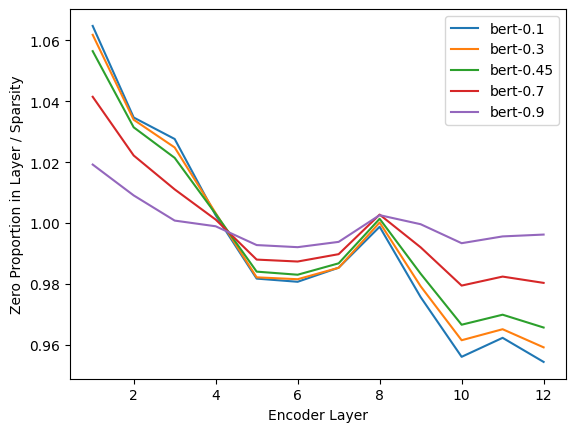

In [190]:
lst = [i+1 for i in range(12)]
plt.plot(lst, ratios_01, label="bert-0.1")
plt.plot(lst, ratios_03, label="bert-0.3")
plt.plot(lst, ratios_045, label="bert-0.45")
plt.plot(lst, ratios_07, label="bert-0.7")
plt.plot(lst, ratios_09, label="bert-0.9")
plt.xlabel("Encoder Layer")
plt.ylabel("Zero Proportion in Layer / Sparsity")
plt.legend()
plt.savefig("")